In [29]:
def example_downforce_curve(speed):
    a = 0.09
    b = 2.5
    c = 5
    return max(0, a * speed * speed + b * speed + c)

def example_drag_curve(speed):
    a = 0.08
    b = 2
    c = 0
    return max(0, a * speed * speed + b * speed + c)


class Front_wing:
    def __init__(self, downforce_curve, drag_curve):
        self.downforce_curve = downforce_curve
        self.drag_curve = drag_curve
    
    def downforce(self, speed):
        return self.downforce_curve(speed)

    def drag(self, speed):
        return self.drag_curve(speed)
    
f_w = Front_wing(example_downforce_curve, example_drag_curve)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Aeorynamic curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

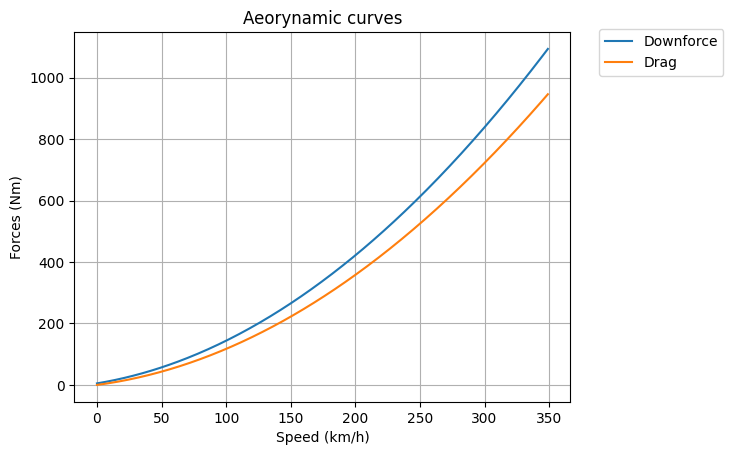

In [30]:
def plot_downforce_curve(wing):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.downforce(kph_to_ms(speed)) for speed in speeds]
    drag_values = [wing.drag(kph_to_ms(speed)) for speed in speeds]

    fig, ax = plt.subplots()
    ax.plot(speeds, downforce_values, label="Downforce")
    ax.plot(speeds, drag_values, label="Drag")
    ax.grid()
    ax.set_title('Aeorynamic curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

plot_downforce_curve(f_w)